In [0]:
!nvidia-smi

Tue Nov 19 12:45:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import numpy as np

**Download Shakespeare Dataset**



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2019-11-18 13:45:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-11-18 13:45:28 (124 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



**Define Tokenizer and prepare training data**

In [0]:
tokenizer = Tokenizer()

data= open('/tmp/sonnets.txt').read()

corpus = data.lower().split('\n')

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'to': 3, 'of': 4, 'my': 5, 'i': 6, 'in': 7, 'that': 8, 'thy': 9, 'thou': 10, 'with': 11, 'for': 12, 'is': 13, 'love': 14, 'not': 15, 'but': 16, 'a': 17, 'me': 18, 'thee': 19, 'so': 20, 'be': 21, 'as': 22, 'all': 23, 'you': 24, 'his': 25, 'which': 26, 'when': 27, 'it': 28, 'this': 29, 'by': 30, 'your': 31, 'doth': 32, 'do': 33, 'from': 34, 'on': 35, 'or': 36, 'no': 37, 'then': 38, 'have': 39, 'what': 40, 'are': 41, 'if': 42, 'more': 43, 'mine': 44, 'their': 45, 'shall': 46, 'sweet': 47, 'time': 48, 'will': 49, 'they': 50, 'beauty': 51, 'nor': 52, 'eyes': 53, 'art': 54, 'her': 55, 'heart': 56, 'yet': 57, 'o': 58, 'than': 59, 'can': 60, 'should': 61, 'thine': 62, 'now': 63, 'where': 64, 'make': 65, 'one': 66, 'hath': 67, 'he': 68, 'fair': 69, 'still': 70, 'how': 71, 'eye': 72, 'him': 73, 'like': 74, 'true': 75, 'see': 76, 'am': 77, 'she': 78, 'those': 79, 'though': 80, 'being': 81, 'some': 82, 'every': 83, 'such': 84, 'own': 85, 'were': 86, 'dost': 87, 'who': 88, 'liv

In [0]:
input_sequences = []

for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

print(len(input_sequences))

#pad sequences
max_sequence_len = max([len(seq) for seq in input_sequences])

print(max_sequence_len, total_words)

input_sequences = np.array(pad_sequences(input_sequences, padding='pre', maxlen=max_sequence_len))

#create predictors and labels
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


15462
11 3211


**Define the Model Architecture and start training**

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (N

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(xs, ys, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 32s 2ms/sample - loss: 6.9861 - acc: 0.0214
Epoch 2/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.5158 - acc: 0.0219
Epoch 3/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.4139 - acc: 0.0257
Epoch 4/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.2960 - acc: 0.0335
Epoch 5/100
15462/15462 [==============================] - 30s 2ms/sample - loss: 6.1758 - acc: 0.0389
Epoch 6/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.0598 - acc: 0.0417
Epoch 7/100
15462/15462 [==============================] - 30s 2ms/sample - loss: 5.9327 - acc: 0.0460
Epoch 8/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 5.8098 - acc: 0.0517
Epoch 9/100
15462/15462 [==============================] - 

**Plot the accuracy graph over epochs**

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()



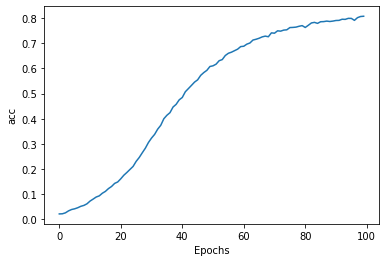

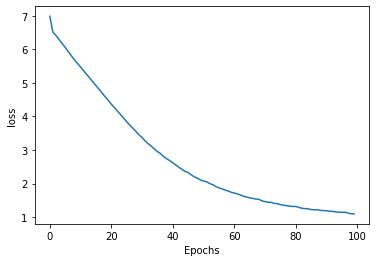

In [0]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

We can see that the accuracy improves with every epoch. We train over 100 epochs and reach around 80 percent accuracy

**Let's train the model for another 90 epochs**

In [0]:
history_v2 = model.fit(xs, ys, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 1.0983 - acc: 0.8037
Epoch 2/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0963 - acc: 0.8057
Epoch 3/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0955 - acc: 0.8047
Epoch 4/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0662 - acc: 0.8124
Epoch 5/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0793 - acc: 0.8064
Epoch 6/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0791 - acc: 0.8084
Epoch 7/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0520 - acc: 0.8139
Epoch 8/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0395 - acc: 0.8139
Epoch 9/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 1.0421 - acc: 0.8130
Epoch 10/100
15462/15462 [========================

**Save the model**

In [0]:
model.save('shakespeare_model.h5')

**Generate 100 next words with an initial sample sentence**

In [0]:
def predict_next_words(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word

  print(seed_text)
  return seed_text

In [0]:
seed_text = "from fairest creatures we desire increase"
next_words = 100


generated_text = predict_next_words(seed_text, next_words)

from fairest creatures we desire increase small face heaven live long wide slow minutes lively far but still kind o'er proceed away away o'er sway impart more alchemy gone still new new made when most dear love gives thee of thee not new rhyme ill new lies slain near slain tend ill ill ill doth can thee kind alone like him up his trim play'st burn'd burn'd near gay mother life still back doth some cruel tend alone bred truly tend ' open spite to cross stay his end dead cured show'st near admire expire new near abuse me express'd dead lie with thee new lack


In [0]:
seed_text = "why lovest thou that which thou receivest not gladly,"
generated_text = predict_next_words(seed_text, next_words)

why lovest thou that which thou receivest not gladly, gladly change things life dead brow new lack lie to my life still doth some cross ' bred another youth their night ' still doth date rage of life but therein quite gone straight lack dead face dead young thee hour mine eye some ill alone doth stay thy hate must care you moan still o'er hell or woe remain new fire ' must do bring all rest fitted tongue forgot thus three near contents stay your place must seen have near forth o'er truth still truly dwell to groan things tend ill doth hide to thee in me bring
